In [33]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

from eli5.sklearn import PermutationImportance
from eli5 import show_weights

import shap

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [3]:
path = Path('../../../data/2021_evraz')

In [4]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 167)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,2950,2960,980,0,0,0,14080,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,2930,0,960,0,0,1060,18830,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,2990,2960,1050,0,0,990,16080,0,0


In [5]:
test = pd.read_pickle(path.joinpath('test_all.pkl'))
print(test.shape)
test.head(3)

(780, 165)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1310,1670,0,0,0,0,13960,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,0,0,0,0,0,15290,0,50
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,0,0,0,0,0,20010,0,1400


In [6]:
X_train, X_valid = train_test_split(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.75, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train['TST'], train_size=0.75, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train['C'], train_size=0.75, random_state=1)

# ELI5 реализация

In [7]:
model_t = xgb.XGBRegressor()
model_t.fit(X_train, y_train_t)

model_c = xgb.XGBRegressor()
model_c.fit(X_train, y_train_c)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
estimator_t = PermutationImportance(
    model_t, scoring='neg_mean_squared_error', random_state=27
)
estimator_c = PermutationImportance(
    model_c, scoring='neg_mean_squared_error', random_state=27
)

importance_t = estimator_t.fit(X_valid, y_valid_t)
importance_c = estimator_c.fit(X_valid, y_valid_c)

In [9]:
show_weights(importance_t, feature_names=X_valid.columns.tolist(), top=X_valid.shape[1])

Weight,Feature
525.1558 ± 115.8636,durat_Doduvkanat
186.4624 ± 33.9313,durat_DoduvkanaC
41.7713 ± 13.8897,O2_DoduvkanaC
33.1184 ± 6.0092,durat_Produvka
31.4339 ± 18.7430,durat_Ohl.azotom
28.1804 ± 8.6081,plavka_NAPR_ZAD_MNLZ
27.6165 ± 17.8030,plavka_NAPR_ZAD_Izl
18.5764 ± 9.0265,O2_Doduvkanat
13.7372 ± 5.6646,plavka_NMZ_S2.1
11.6762 ± 7.9298,CO2


In [10]:
show_weights(importance_c, feature_names=X_valid.columns.tolist(), top=X_valid.shape[1])

Weight,Feature
0.0022 ± 0.0006,plavka_NMZ_S2.1
0.0021 ± 0.0009,plavka_NMZ_S2.3
0.0006 ± 0.0001,durat_DoduvkanaC
0.0004 ± 0.0001,CO2
0.0002 ± 0.0004,Tfurmy1
0.0002 ± 0.0001,durat_Doduvkanat
0.0001 ± 0.0002,NPLV
0.0001 ± 0.0002,NMSYP_izv_ZOI
0.0001 ± 0.0001,O2_DoduvkanaC
0.0001 ± 0.0000,O2_pressure


# самописная реализация

In [12]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [13]:
model_t = xgb.XGBRegressor()
model_t.fit(X_train, y_train_t)

model_c = xgb.XGBRegressor()
model_c.fit(X_train, y_train_c)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
estimator_t = PermutationImportance(
    model_t, scoring=mean_squared_error, random_state=27
)
estimator_c = PermutationImportance(
    model_c, scoring=mean_squared_error, random_state=27
)

In [15]:
scores_t, importance_t = calculate_permutation_importance(
    estimator_t, mean_squared_error, X_valid, y_valid_t
)

100%|███████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 171.24it/s]


In [16]:
scores_c, importance_c = calculate_permutation_importance(
    estimator_c, mean_squared_error, X_valid, y_valid_c
)

100%|███████████████████████████████████████████████████████████████████████████████| 164/164 [00:01<00:00, 160.65it/s]


In [17]:
importance_t

VES_4_K                        6.856708
durat_Zavalkaloma              6.408270
Tfurmy2                        4.950235
plavka_TIPE_GOL_4-soplx54      4.482726
durat_Preryv.vypuska           3.201815
                                ...    
durat_Ohl.azotom             -26.759787
durat_Produvka               -29.998349
O2_DoduvkanaC                -63.700110
durat_DoduvkanaC            -212.269514
durat_Doduvkanat            -468.379586
Length: 164, dtype: float64

In [18]:
importance_c

durat_Produvka      0.000569
T_y                 0.000225
VES_13_KP           0.000075
NMSYP_FlusFOMI      0.000053
SI                  0.000048
                      ...   
NPLV               -0.000354
CO2                -0.000472
durat_DoduvkanaC   -0.000866
plavka_NMZ_S2.3    -0.000938
plavka_NMZ_S2.1    -0.002027
Length: 164, dtype: float64

In [41]:
to_drop_t = importance_t[importance_t>=0].index.tolist()

In [42]:
to_drop_c = importance_c[importance_c>=0].index.tolist()

In [43]:
drop_list = ['TST', 'C', 'DATA_ZAMERA']
drop_list.extend(to_drop_t)
drop_list.extend(to_drop_c)

In [44]:
drop_list

['TST',
 'C',
 'DATA_ZAMERA',
 'VES_4_K',
 'durat_Zavalkaloma',
 'Tfurmy2',
 'plavka_TIPE_GOL_4-soplx54',
 'durat_Preryv.vypuska',
 'TI',
 'V_y',
 'VES_61_KSS8',
 'CR',
 'AR',
 'P',
 'plavka_NMZ_G_ET',
 'CO',
 'plavka_TIPE_GOL_5soplovaa',
 'O2_Nagrevloma',
 'plavka_NMZ_SC2M_ET',
 'plavka_NMZ_St3sp',
 'CU',
 'plavka_NMZ_4SP.z08_ET',
 'NMSYP_Ugol_TO',
 'plavka_NMZ_S2.3',
 'VES_23_LC',
 'NMSYP_izvotsev',
 'plavka_NAPR_ZAD_MNLS',
 'plavka_NMZ_09G2S.16',
 'plavka_NMZ_SPHC.z03_ET',
 'plavka_TIPE_FUR_koniceskaa',
 'plavka_NMZ_SC2_ET',
 'NI',
 'plavka_NMZ_10B33_ET',
 'O2_pressure',
 'plavka_NMZ_1PS.z01_ET',
 'plavka_NMZ_09G2S',
 'VES_20_OK',
 'plavka_NMZ_5SP.z16_ET',
 'plavka_TIPE_GOL_4-soplh54',
 'plavka_NMZ_ST3GSP.2',
 'plavka_NMZ_ST3PS.7',
 'plavka_NMZ_ST3PS.6',
 'plavka_NMZ_ST3GSP.4',
 'plavka_NMZ_C06ESM.z01_ET',
 'plavka_NMZ_SP325_ET',
 'plavka_NMZ_SC3.z01_ET',
 'plavka_NMZ_SAE1008.z13_ET',
 'plavka_NMZ_SV08G2S.2',
 'plavka_NMZ_GR60.z02_ET',
 'plavka_NMZ_CQ2-G60_ET',
 'plavka_NMZ_C121TM_E

In [45]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8871, train-score 2 = 0.9873
valid-score 1 = 0.4176, valid-score 2 = 0.5671
Train metric =  0.933
Valid metric =  0.6525
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8844, train-score 2 = 0.986
valid-score 1 = 0.4118, valid-score 2 = 0.5139
Train metric =  0.9312
Valid metric =  0.6864
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8989, train-score 2 = 0.9887
valid-score 1 = 0.5344, valid-score 2 = 0.5353
Train metric =  0.9506
Valid metric =  0.6174
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8782, train-score 2 = 0.9876
valid-score 1 = 0.5966, valid-score 2 = 0.7592
Train metric =  0.9385
Valid metric =  0.6723


  4%|███▎                                                                               | 1/25 [00:01<00:30,  1.25s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8888, train-score 2 = 0.9856
valid-score 1 = 0.4397, valid-score 2 = 0.5124
Train metric =  0.9303
Valid metric =  0.6687
CV-results train 1: 0.8875 +/- 0.007
CV-results train 2: 0.987 +/- 0.001
CV-results valid 1: 0.48 +/- 0.073
CV-results valid 2: 0.5776 +/- 0.093
OOF-score 1 = 0.4905
OOF-score 2 = 0.5685
CV-results evraz metric train: 0.9367+/- 0.007
CV-results evraz metric valid: 0.6595+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8809, train-score 2 = 0.9866
valid-score 1 = 0.4137, valid-score 2 = 0.5666
Train metric =  0.9261
Valid metric =  0.6513
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8826, train-score 2 = 0.9854
valid-score 1 = 0.4123, valid-score 2 = 0.5151
Train metric =  0.9303
Valid metric =  0.6877
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8913, train-score 2 = 0.9882
valid-sc

  8%|██████▋                                                                            | 2/25 [00:02<00:25,  1.12s/it]

CV-results train 1: 0.8817 +/- 0.006
CV-results train 2: 0.9863 +/- 0.001
CV-results valid 1: 0.4795 +/- 0.073
CV-results valid 2: 0.5779 +/- 0.093
OOF-score 1 = 0.4898
OOF-score 2 = 0.5689
CV-results evraz metric train: 0.9315+/- 0.007
CV-results evraz metric valid: 0.6602+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8759, train-score 2 = 0.9856
valid-score 1 = 0.4079, valid-score 2 = 0.5662
Train metric =  0.9233
Valid metric =  0.6465
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8791, train-score 2 = 0.9849
valid-score 1 = 0.4108, valid-score 2 = 0.5147
Train metric =  0.9264
Valid metric =  0.684
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8809, train-score 2 = 0.9875
valid-score 1 = 0.5381, valid-score 2 = 0.5364
Train metric =  0.9373
Valid metric =  0.6223
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8657, train-score 2 = 0.9855
valid-

 12%|█████████▉                                                                         | 3/25 [00:03<00:24,  1.13s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8807, train-score 2 = 0.983
valid-score 1 = 0.4505, valid-score 2 = 0.5122
Train metric =  0.9231
Valid metric =  0.6663
CV-results train 1: 0.8764 +/- 0.006
CV-results train 2: 0.9853 +/- 0.001
CV-results valid 1: 0.4794 +/- 0.072
CV-results valid 2: 0.5775 +/- 0.092
OOF-score 1 = 0.4889
OOF-score 2 = 0.5685
CV-results evraz metric train: 0.9271+/- 0.005
CV-results evraz metric valid: 0.6583+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8712, train-score 2 = 0.9847
valid-score 1 = 0.4118, valid-score 2 = 0.5661
Train metric =  0.9197
Valid metric =  0.6416
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8712, train-score 2 = 0.9842
valid-score 1 = 0.4158, valid-score 2 = 0.515
Train metric =  0.9185
Valid metric =  0.6864
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8753, train-score 2 = 0.9872
valid-s

 16%|█████████████▎                                                                     | 4/25 [00:04<00:22,  1.08s/it]

CV-results train 1: 0.8718 +/- 0.005
CV-results train 2: 0.9846 +/- 0.002
CV-results valid 1: 0.4819 +/- 0.071
CV-results valid 2: 0.5774 +/- 0.093
OOF-score 1 = 0.4914
OOF-score 2 = 0.5683
CV-results evraz metric train: 0.9227+/- 0.006
CV-results evraz metric valid: 0.6583+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8664, train-score 2 = 0.9832
valid-score 1 = 0.4118, valid-score 2 = 0.566
Train metric =  0.9118
Valid metric =  0.6429
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8644, train-score 2 = 0.9837
valid-score 1 = 0.4157, valid-score 2 = 0.5106
Train metric =  0.9152
Valid metric =  0.6864
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8734, train-score 2 = 0.9866
valid-score 1 = 0.539, valid-score 2 = 0.5365
Train metric =  0.9318
Valid metric =  0.6235
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8558, train-score 2 = 0.9838
valid-s

 20%|████████████████▌                                                                  | 5/25 [00:05<00:21,  1.06s/it]

CV-results train 1: 0.8666 +/- 0.006
CV-results train 2: 0.9837 +/- 0.002
CV-results valid 1: 0.4827 +/- 0.072
CV-results valid 2: 0.577 +/- 0.093
OOF-score 1 = 0.4922
OOF-score 2 = 0.5679
CV-results evraz metric train: 0.9177+/- 0.007
CV-results evraz metric valid: 0.6607+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8613, train-score 2 = 0.9827
valid-score 1 = 0.4105, valid-score 2 = 0.5654
Train metric =  0.907
Valid metric =  0.6441
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8594, train-score 2 = 0.9824
valid-score 1 = 0.4254, valid-score 2 = 0.5087
Train metric =  0.9085
Valid metric =  0.6877
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8698, train-score 2 = 0.9854
valid-score 1 = 0.5397, valid-score 2 = 0.536
Train metric =  0.9255
Valid metric =  0.6259
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8516, train-score 2 = 0.983
valid-sco

 24%|███████████████████▉                                                               | 6/25 [00:06<00:19,  1.00s/it]

CV-results train 1: 0.8614 +/- 0.006
CV-results train 2: 0.9826 +/- 0.002
CV-results valid 1: 0.4859 +/- 0.07
CV-results valid 2: 0.5759 +/- 0.093
OOF-score 1 = 0.4948
OOF-score 2 = 0.5666
CV-results evraz metric train: 0.9117+/- 0.007
CV-results evraz metric valid: 0.6624+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8556, train-score 2 = 0.9814
valid-score 1 = 0.4074, valid-score 2 = 0.5635
Train metric =  0.8967
Valid metric =  0.6465
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.855, train-score 2 = 0.9817
valid-score 1 = 0.4267, valid-score 2 = 0.5048
Train metric =  0.9018
Valid metric =  0.6889
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8652, train-score 2 = 0.9843
valid-score 1 = 0.5352, valid-score 2 = 0.5354
Train metric =  0.9218
Valid metric =  0.6199
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8462, train-score 2 = 0.9819
valid-s

 28%|███████████████████████▏                                                           | 7/25 [00:07<00:18,  1.00s/it]

CV-results train 1: 0.8561 +/- 0.006
CV-results train 2: 0.9815 +/- 0.002
CV-results valid 1: 0.4858 +/- 0.069
CV-results valid 2: 0.5749 +/- 0.094
OOF-score 1 = 0.4943
OOF-score 2 = 0.5656
CV-results evraz metric train: 0.9047+/- 0.009
CV-results evraz metric valid: 0.6612+/- 0.025
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8498, train-score 2 = 0.9807
valid-score 1 = 0.4074, valid-score 2 = 0.5636
Train metric =  0.8903
Valid metric =  0.6453
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8505, train-score 2 = 0.9806
valid-score 1 = 0.4275, valid-score 2 = 0.5035
Train metric =  0.893
Valid metric =  0.6877
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8534, train-score 2 = 0.9831
valid-score 1 = 0.5286, valid-score 2 = 0.5366
Train metric =  0.9112
Valid metric =  0.6211


 32%|██████████████████████████▌                                                        | 8/25 [00:08<00:15,  1.07it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8389, train-score 2 = 0.9812
valid-score 1 = 0.5943, valid-score 2 = 0.7589
Train metric =  0.8995
Valid metric =  0.6772
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.852, train-score 2 = 0.9768
valid-score 1 = 0.4699, valid-score 2 = 0.514
Train metric =  0.8901
Valid metric =  0.6663
CV-results train 1: 0.8489 +/- 0.005
CV-results train 2: 0.9805 +/- 0.002
CV-results valid 1: 0.4855 +/- 0.068
CV-results valid 2: 0.5753 +/- 0.094
OOF-score 1 = 0.4937
OOF-score 2 = 0.566
CV-results evraz metric train: 0.8968+/- 0.008
CV-results evraz metric valid: 0.6595+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8407, train-score 2 = 0.9793
valid-score 1 = 0.4019, valid-score 2 = 0.5618
Train metric =  0.8848
Valid metric =  0.6416
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8391, train-score 2 = 0.9799
valid-sc

 36%|█████████████████████████████▉                                                     | 9/25 [00:08<00:14,  1.11it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8486, train-score 2 = 0.9753
valid-score 1 = 0.4704, valid-score 2 = 0.5135
Train metric =  0.8822
Valid metric =  0.6626
CV-results train 1: 0.8405 +/- 0.006
CV-results train 2: 0.9793 +/- 0.002
CV-results valid 1: 0.4847 +/- 0.071
CV-results valid 2: 0.575 +/- 0.094
OOF-score 1 = 0.4929
OOF-score 2 = 0.5658
CV-results evraz metric train: 0.8898+/- 0.009
CV-results evraz metric valid: 0.6576+/- 0.028
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8336, train-score 2 = 0.9777
valid-score 1 = 0.4017, valid-score 2 = 0.5585
Train metric =  0.877
Valid metric =  0.6465
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8266, train-score 2 = 0.9787
valid-score 1 = 0.4409, valid-score 2 = 0.5034
Train metric =  0.8785
Valid metric =  0.6949
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8335, train-score 2 = 0.9809
valid-s

 40%|████████████████████████████████▊                                                 | 10/25 [00:09<00:13,  1.15it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8211, train-score 2 = 0.9781
valid-score 1 = 0.594, valid-score 2 = 0.7566
Train metric =  0.8825
Valid metric =  0.6869
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8328, train-score 2 = 0.973
valid-score 1 = 0.4762, valid-score 2 = 0.5127
Train metric =  0.8661
Valid metric =  0.6675
CV-results train 1: 0.8295 +/- 0.005
CV-results train 2: 0.9777 +/- 0.003
CV-results valid 1: 0.4887 +/- 0.068
CV-results valid 2: 0.5738 +/- 0.093
OOF-score 1 = 0.4962
OOF-score 2 = 0.5648
CV-results evraz metric train: 0.8804+/- 0.01
CV-results evraz metric valid: 0.6631+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8221, train-score 2 = 0.9757
valid-score 1 = 0.3896, valid-score 2 = 0.5595
Train metric =  0.8697
Valid metric =  0.6453
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8161, train-score 2 = 0.9768
valid-sc

 44%|████████████████████████████████████                                              | 11/25 [00:10<00:11,  1.22it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8212, train-score 2 = 0.9715
valid-score 1 = 0.4786, valid-score 2 = 0.5137
Train metric =  0.8586
Valid metric =  0.6735
CV-results train 1: 0.8179 +/- 0.007
CV-results train 2: 0.9759 +/- 0.002
CV-results valid 1: 0.4872 +/- 0.071
CV-results valid 2: 0.5747 +/- 0.094
OOF-score 1 = 0.4945
OOF-score 2 = 0.5657
CV-results evraz metric train: 0.8713+/- 0.009
CV-results evraz metric valid: 0.6672+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8129, train-score 2 = 0.9739
valid-score 1 = 0.3819, valid-score 2 = 0.5567
Train metric =  0.8597
Valid metric =  0.6465
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8052, train-score 2 = 0.9743
valid-score 1 = 0.4414, valid-score 2 = 0.502
Train metric =  0.8564
Valid metric =  0.701
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8133, train-score 2 = 0.977
valid-sc

 48%|███████████████████████████████████████▎                                          | 12/25 [00:11<00:10,  1.26it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7855, train-score 2 = 0.9754
valid-score 1 = 0.5975, valid-score 2 = 0.7583
Train metric =  0.8613
Valid metric =  0.6905
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8034, train-score 2 = 0.9699
valid-score 1 = 0.4798, valid-score 2 = 0.5124
Train metric =  0.8416
Valid metric =  0.6735
CV-results train 1: 0.8041 +/- 0.01
CV-results train 2: 0.9741 +/- 0.002
CV-results valid 1: 0.4836 +/- 0.072
CV-results valid 2: 0.5739 +/- 0.094
OOF-score 1 = 0.4906
OOF-score 2 = 0.565
CV-results evraz metric train: 0.8588+/- 0.011
CV-results evraz metric valid: 0.6672+/- 0.028
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7922, train-score 2 = 0.9725
valid-score 1 = 0.3602, valid-score 2 = 0.5538
Train metric =  0.8439
Valid metric =  0.6356
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7831, train-score 2 = 0.9731
valid-s

 52%|██████████████████████████████████████████▋                                       | 13/25 [00:11<00:08,  1.34it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.791, train-score 2 = 0.9676
valid-score 1 = 0.5037, valid-score 2 = 0.5093
Train metric =  0.8304
Valid metric =  0.6784
CV-results train 1: 0.7883 +/- 0.009
CV-results train 2: 0.9722 +/- 0.003
CV-results valid 1: 0.4835 +/- 0.078
CV-results valid 2: 0.5717 +/- 0.096
OOF-score 1 = 0.4886
OOF-score 2 = 0.5626
CV-results evraz metric train: 0.8466+/- 0.012
CV-results evraz metric valid: 0.668+/- 0.03
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7709, train-score 2 = 0.9706
valid-score 1 = 0.3374, valid-score 2 = 0.5475
Train metric =  0.8303
Valid metric =  0.6295
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7662, train-score 2 = 0.9709
valid-score 1 = 0.4416, valid-score 2 = 0.497
Train metric =  0.8282
Valid metric =  0.6985
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7772, train-score 2 = 0.9742
valid-sco

 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:12<00:07,  1.41it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7451, train-score 2 = 0.9703
valid-score 1 = 0.5845, valid-score 2 = 0.7585
Train metric =  0.8295
Valid metric =  0.6917
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7692, train-score 2 = 0.9649
valid-score 1 = 0.5067, valid-score 2 = 0.5098
Train metric =  0.8156
Valid metric =  0.6711
CV-results train 1: 0.7657 +/- 0.011
CV-results train 2: 0.9702 +/- 0.003
CV-results valid 1: 0.4744 +/- 0.082
CV-results valid 2: 0.5704 +/- 0.096
OOF-score 1 = 0.4784
OOF-score 2 = 0.5616
CV-results evraz metric train: 0.831+/- 0.012
CV-results evraz metric valid: 0.6619+/- 0.032
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7392, train-score 2 = 0.9677
valid-score 1 = 0.2849, valid-score 2 = 0.5518
Train metric =  0.8109
Valid metric =  0.6344
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7383, train-score 2 = 0.9695
valid-

 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:13<00:06,  1.46it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7419, train-score 2 = 0.9598
valid-score 1 = 0.5023, valid-score 2 = 0.5098
Train metric =  0.798
Valid metric =  0.6735
CV-results train 1: 0.7375 +/- 0.011
CV-results train 2: 0.9676 +/- 0.004
CV-results valid 1: 0.4537 +/- 0.097
CV-results valid 2: 0.5705 +/- 0.095
OOF-score 1 = 0.4567
OOF-score 2 = 0.5615
CV-results evraz metric train: 0.8156+/- 0.013
CV-results evraz metric valid: 0.6612+/- 0.031
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6836, train-score 2 = 0.9652
valid-score 1 = 0.2069, valid-score 2 = 0.5503
Train metric =  0.7827
Valid metric =  0.6114
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6847, train-score 2 = 0.9655
valid-score 1 = 0.4078, valid-score 2 = 0.4904
Train metric =  0.7815
Valid metric =  0.6768
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6884, train-score 2 = 0.9712
valid-

 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:13<00:05,  1.55it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6625, train-score 2 = 0.9658
valid-score 1 = 0.5526, valid-score 2 = 0.7548
Train metric =  0.7877
Valid metric =  0.6711
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6858, train-score 2 = 0.9581
valid-score 1 = 0.4805, valid-score 2 = 0.5056
Train metric =  0.7735
Valid metric =  0.6638
CV-results train 1: 0.681 +/- 0.009
CV-results train 2: 0.9651 +/- 0.004
CV-results valid 1: 0.415 +/- 0.116
CV-results valid 2: 0.5678 +/- 0.096
OOF-score 1 = 0.4168
OOF-score 2 = 0.5587
CV-results evraz metric train: 0.7871+/- 0.012
CV-results evraz metric valid: 0.6457+/- 0.031
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.5944, train-score 2 = 0.9616
valid-score 1 = 0.0927, valid-score 2 = 0.5518
Train metric =  0.7421
Valid metric =  0.5884
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.5933, train-score 2 = 0.9626
valid-s

 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:14<00:05,  1.52it/s]

CV-results train 1: 0.59 +/- 0.012
CV-results train 2: 0.9615 +/- 0.004
CV-results valid 1: 0.3165 +/- 0.13
CV-results valid 2: 0.5677 +/- 0.096
OOF-score 1 = 0.3232
OOF-score 2 = 0.5585
CV-results evraz metric train: 0.7471+/- 0.012
CV-results evraz metric valid: 0.6185+/- 0.028
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4195, train-score 2 = 0.9577
valid-score 1 = -0.0831, valid-score 2 = 0.5478
Train metric =  0.6785
Valid metric =  0.5496
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4275, train-score 2 = 0.9578
valid-score 1 = 0.2029, valid-score 2 = 0.4871
Train metric =  0.6845
Valid metric =  0.6029
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.423, train-score 2 = 0.9632
valid-score 1 = 0.1672, valid-score 2 = 0.5379
Train metric =  0.6964
Valid metric =  0.5412
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.3917, train-score 2 = 0.9582
valid-sc

 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:14<00:04,  1.57it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4456, train-score 2 = 0.9487
valid-score 1 = 0.1457, valid-score 2 = 0.5022
Train metric =  0.6753
Valid metric =  0.5813
CV-results train 1: 0.4215 +/- 0.017
CV-results train 2: 0.9571 +/- 0.005
CV-results valid 1: 0.1653 +/- 0.152
CV-results valid 2: 0.5661 +/- 0.097
OOF-score 1 = 0.1756
OOF-score 2 = 0.5569
CV-results evraz metric train: 0.6844+/- 0.007
CV-results evraz metric valid: 0.5795+/- 0.031
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.0924, train-score 2 = 0.9535
valid-score 1 = -0.4018, valid-score 2 = 0.5431
Train metric =  0.5779
Valid metric =  0.4831
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1093, train-score 2 = 0.9522
valid-score 1 = -0.0784, valid-score 2 = 0.4842
Train metric =  0.5836
Valid metric =  0.5
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.099, train-score 2 = 0.9562
valid-s

 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:15<00:03,  1.64it/s]


Train metric =  0.5809
Valid metric =  0.557
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.1503, train-score 2 = 0.9413
valid-score 1 = -0.2149, valid-score 2 = 0.4972
Train metric =  0.5669
Valid metric =  0.5036
CV-results train 1: 0.1006 +/- 0.031
CV-results train 2: 0.9513 +/- 0.005
CV-results valid 1: -0.1393 +/- 0.189
CV-results valid 2: 0.564 +/- 0.099
OOF-score 1 = -0.1218
OOF-score 2 = 0.5548
CV-results evraz metric train: 0.5797+/- 0.007
CV-results evraz metric valid: 0.4971+/- 0.037
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5465, train-score 2 = 0.9436
valid-score 1 = -0.9685, valid-score 2 = 0.5338
Train metric =  0.4297
Valid metric =  0.3826
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -0.502, train-score 2 = 0.9432
valid-score 1 = -0.7186, valid-score 2 = 0.4708
Train metric =  0.4321
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
t

 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:16<00:03,  1.66it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -0.4321, train-score 2 = 0.9292
valid-score 1 = -0.9898, valid-score 2 = 0.4961
Train metric =  0.4204
Valid metric =  0.3786
CV-results train 1: -0.5231 +/- 0.056
CV-results train 2: 0.9419 +/- 0.007
CV-results valid 1: -0.7512 +/- 0.257
CV-results valid 2: 0.5587 +/- 0.1
OOF-score 1 = -0.7139
OOF-score 2 = 0.5495
CV-results evraz metric train: 0.4325+/- 0.008
CV-results evraz metric valid: 0.3805+/- 0.028
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7979, train-score 2 = 0.933
valid-score 1 = -2.3767, valid-score 2 = 0.5221
Train metric =  0.2876
Valid metric =  0.3027
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7243, train-score 2 = 0.9296
valid-score 1 = -1.9572, valid-score 2 = 0.4583
Train metric =  0.2945
Valid metric =  0.2373
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7984, train-score 2 = 0.938

 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:16<00:02,  1.75it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -1.5892, train-score 2 = 0.9167
valid-score 1 = -2.5567, valid-score 2 = 0.4916
Train metric =  0.2944
Valid metric =  0.2536
CV-results train 1: -1.7632 +/- 0.105
CV-results train 2: 0.9297 +/- 0.007
CV-results valid 1: -2.0248 +/- 0.459
CV-results valid 2: 0.5493 +/- 0.101
OOF-score 1 = -1.9523
OOF-score 2 = 0.5402
CV-results evraz metric train: 0.2969+/- 0.006
CV-results evraz metric valid: 0.2652+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3264, train-score 2 = 0.9133
valid-score 1 = -4.5403, valid-score 2 = 0.5079
Train metric =  0.2042
Valid metric =  0.2155
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -4.163, train-score 2 = 0.9074
valid-score 1 = -4.5054, valid-score 2 = 0.4375
Train metric =  0.2021
Valid metric =  0.155
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3157, train-score 2 = 0.91

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:17<00:01,  1.84it/s]

CV-results train 1: -4.2444 +/- 0.205
CV-results train 2: 0.9073 +/- 0.008
CV-results valid 1: -4.5214 +/- 0.869
CV-results valid 2: 0.5315 +/- 0.102
OOF-score 1 = -4.3575
OOF-score 2 = 0.5221
CV-results evraz metric train: 0.2049+/- 0.004
CV-results evraz metric valid: 0.1878+/- 0.026
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -9.4081, train-score 2 = 0.8775
valid-score 1 = -9.1864, valid-score 2 = 0.4607
Train metric =  0.1294
Valid metric =  0.1162
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -9.0731, train-score 2 = 0.8663
valid-score 1 = -9.7665, valid-score 2 = 0.3921
Train metric =  0.1306
Valid metric =  0.0666
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3963, train-score 2 = 0.873
valid-score 1 = -9.2628, valid-score 2 = 0.4862
Train metric =  0.1191
Valid metric =  0.1162
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -9.7857, train-score 2 = 0.8

 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:17<00:01,  1.95it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -8.5688, train-score 2 = 0.8554
valid-score 1 = -12.9101, valid-score 2 = 0.4329
Train metric =  0.1217
Valid metric =  0.1238
CV-results train 1: -9.2464 +/- 0.407
CV-results train 2: 0.8691 +/- 0.008
CV-results valid 1: -9.6682 +/- 1.84
CV-results valid 2: 0.4929 +/- 0.105
OOF-score 1 = -9.3124
OOF-score 2 = 0.4838
CV-results evraz metric train: 0.1268+/- 0.005
CV-results evraz metric valid: 0.113+/- 0.025
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6918, train-score 2 = 0.8095
valid-score 1 = -18.6148, valid-score 2 = 0.3788
Train metric =  0.08
Valid metric =  0.0617
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -19.0289, train-score 2 = 0.7904
valid-score 1 = -20.5055, valid-score 2 = 0.3152
Train metric =  0.08
Valid metric =  0.0424
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6918, train-score 2 = 0.

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:18<00:00,  1.85it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -20.4706, train-score 2 = 0.8017
valid-score 1 = -15.5332, valid-score 2 = 0.6241
Train metric =  0.0736
Valid metric =  0.0898
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -18.0262, train-score 2 = 0.7782
valid-score 1 = -27.2838, valid-score 2 = 0.3728
Train metric =  0.0694
Valid metric =  0.0558
CV-results train 1: -19.3819 +/- 0.817
CV-results train 2: 0.7957 +/- 0.011
CV-results valid 1: -20.1822 +/- 3.9
CV-results valid 2: 0.4228 +/- 0.106
OOF-score 1 = -19.4295
OOF-score 2 = 0.4146
CV-results evraz metric train: 0.075+/- 0.004
CV-results evraz metric valid: 0.0645+/- 0.016
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -40.6133, train-score 2 = 0.6762
valid-score 1 = -37.8424, valid-score 2 = 0.2008
Train metric =  0.0433
Valid metric =  0.0278
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -39.2731, train-score

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:18<00:00,  1.35it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -42.1649, train-score 2 = 0.6657
valid-score 1 = -32.3896, valid-score 2 = 0.4782
Train metric =  0.0427
Valid metric =  0.0583
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -37.2073, train-score 2 = 0.6297
valid-score 1 = -56.8989, valid-score 2 = 0.2838
Train metric =  0.0433
Valid metric =  0.0267
CV-results train 1: -39.972 +/- 1.658
CV-results train 2: 0.6539 +/- 0.016
CV-results valid 1: -41.5247 +/- 8.294
CV-results valid 2: 0.2878 +/- 0.108
OOF-score 1 = -39.9378
OOF-score 2 = 0.2833
CV-results evraz metric train: 0.0422+/- 0.002
CV-results evraz metric valid: 0.0356+/- 0.014


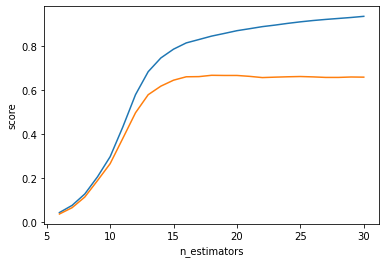

In [47]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(30, 5, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(drop_list, axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=r2_score, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [48]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=17

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(drop_list, axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=r2_score, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7709, train-score 2 = 0.9706
valid-score 1 = 0.3374, valid-score 2 = 0.5475
Train metric =  0.8303
Valid metric =  0.6295
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7662, train-score 2 = 0.9709
valid-score 1 = 0.4416, valid-score 2 = 0.497
Train metric =  0.8282
Valid metric =  0.6985
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7772, train-score 2 = 0.9742
valid-score 1 = 0.5018, valid-score 2 = 0.5391
Train metric =  0.8515
Valid metric =  0.6186
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7451, train-score 2 = 0.9703
valid-score 1 = 0.5845, valid-score 2 = 0.7585
Train metric =  0.8295
Valid metric =  0.6917
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7692, train-score 2 = 0.9649
valid-score 1 = 0.5067, valid-score 2 = 0.5098
Train metric =  0.8156
Valid metric =  0.6

In [49]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(test_pred_2).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1650.238892,0.054307
1,512327,1666.714966,0.071837
2,512328,1650.272461,0.145135
3,512331,1645.914307,0.134054
4,512333,1657.324219,0.127933


In [50]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-17_feat_select_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-17_feat_select_2021-10-31_08-21-35.csv

 File saved to disk!


# SHAP

In [7]:
params = {}

model_t = xgb.XGBRegressor(**params)
model_t.fit(X_train, y_train_t)

model_c = xgb.XGBRegressor(**params)
model_c.fit(X_train, y_train_c)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
# x_valid_t, y_valid_t = X_valid.sample(2000), y_valid_t.sample(2000)
# x_valid_c, y_valid_c = X_valid.sample(2000), y_valid_c.sample(2000)

explainer_t = shap.TreeExplainer(model_t)
explainer_c = shap.TreeExplainer(model_c)

shap_values_t = explainer_t.shap_values(X_valid, y_valid_t)
shap_values_c = explainer_c.shap_values(X_valid, y_valid_c)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [9]:
shap.force_plot(
    explainer_t.expected_value, shap_values_t[0,:], X_valid.iloc[0,:], link="logit"
)

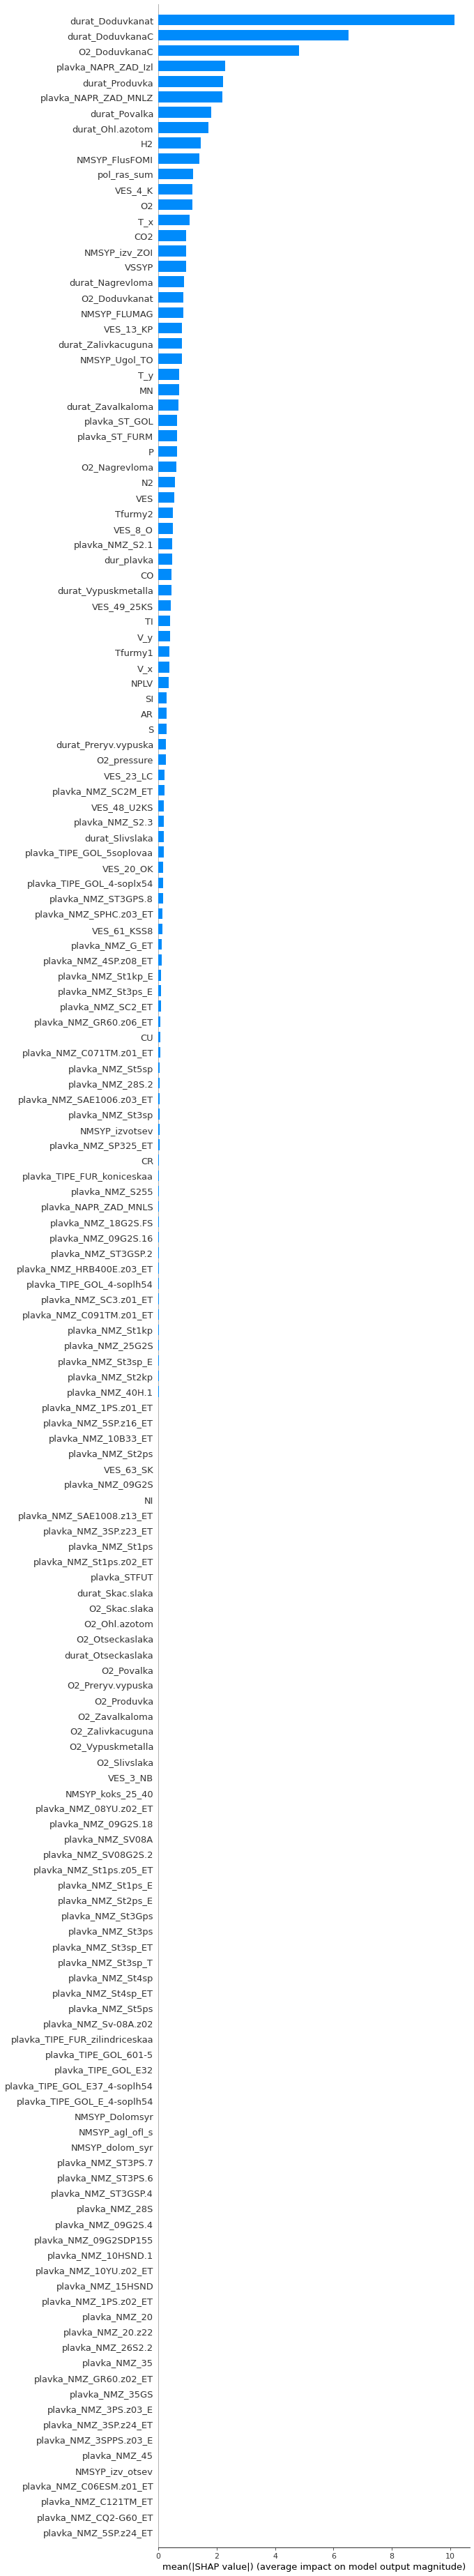

In [12]:
shap.summary_plot(shap_values_t, X_valid, plot_type="bar", max_display=X_valid.shape[1])

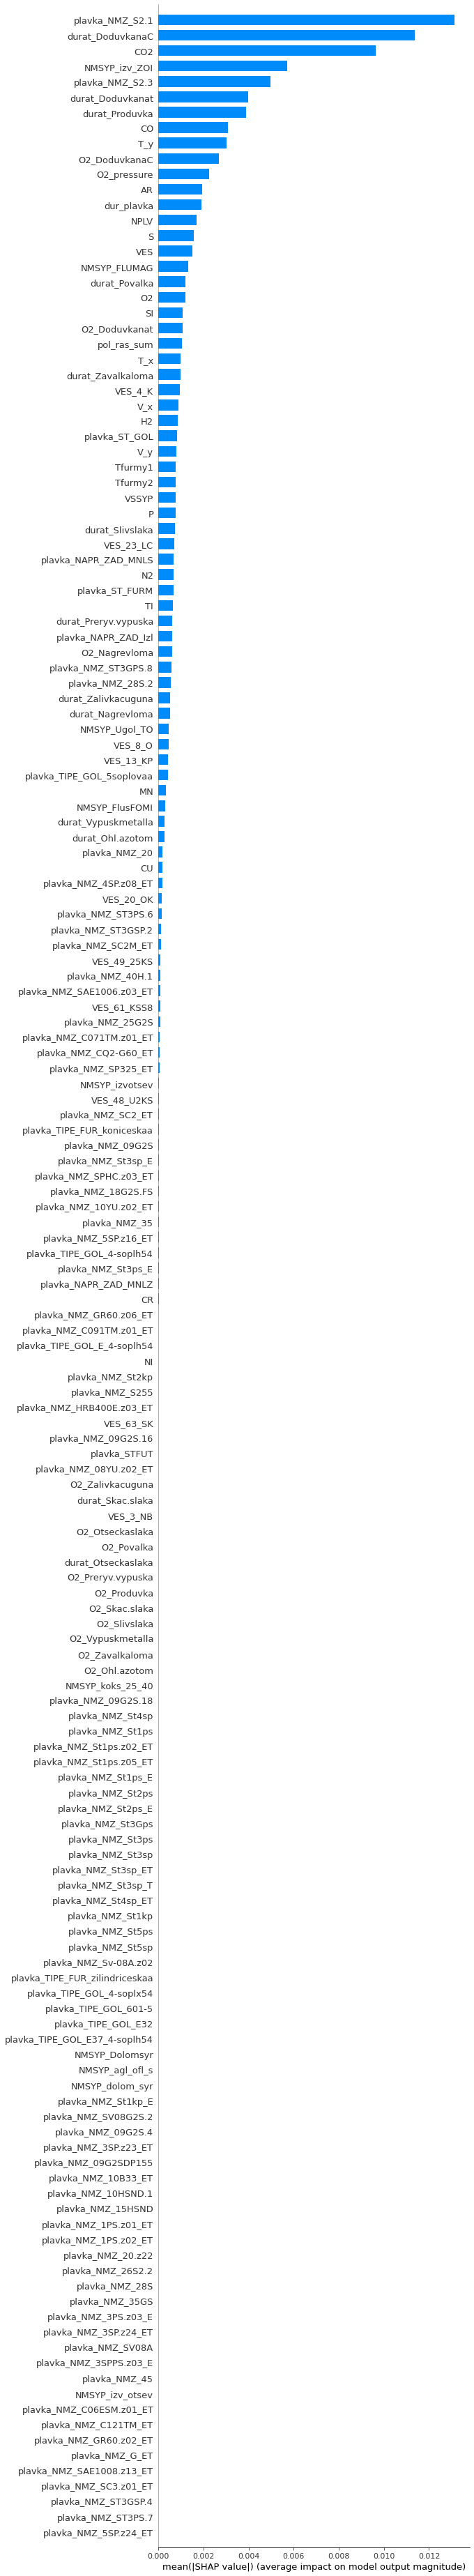

In [14]:
shap.summary_plot(shap_values_c, X_valid, plot_type="bar", max_display=X_valid.shape[1])

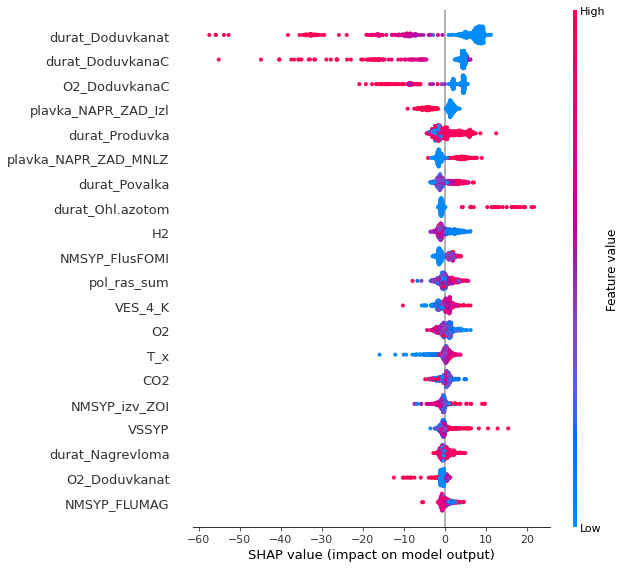

In [15]:
shap.summary_plot(shap_values_t, X_valid)

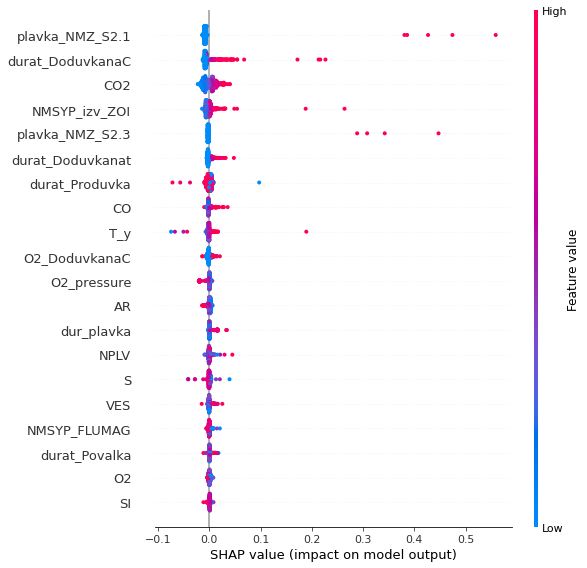

In [16]:
shap.summary_plot(shap_values_c, X_valid)

In [22]:
explainer = shap.TreeExplainer(model_t)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [1648.24632812]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


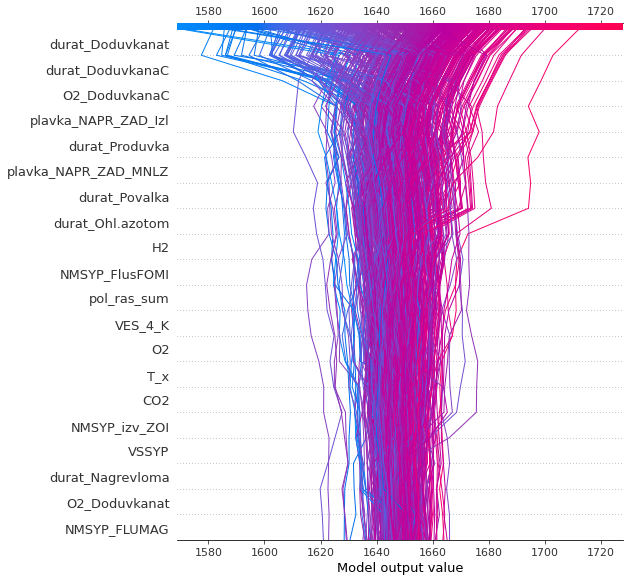

In [23]:
shap.decision_plot(
    expected_value, shap_values_t, features_display.iloc[:20]
)

In [24]:
explainer = shap.TreeExplainer(model_c)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = X_valid.iloc[select]
features_display = X_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [0.0843032]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


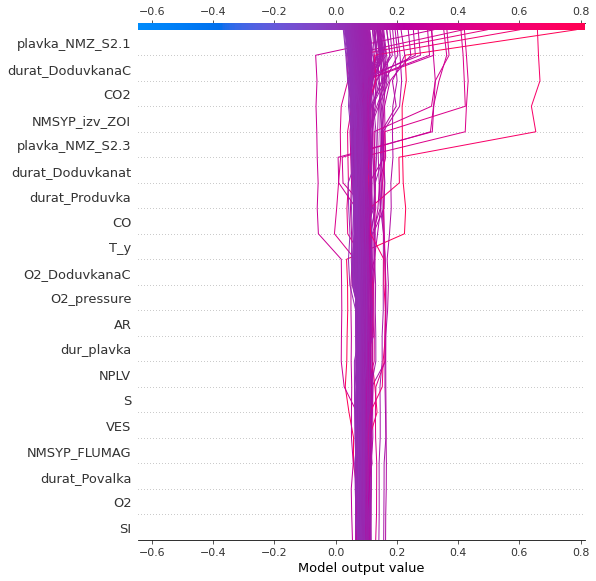

In [25]:
shap.decision_plot(
    expected_value, shap_values_c, features_display.iloc[:20]
)

## Попробуем улучшить модельку на основе permutation-importance

In [22]:
scores, importance = calculate_permutation_importance(
    model, roc_auc_score, x_valid, y_valid
)

100%|██████████| 24/24 [00:02<00:00,  8.99it/s]


In [23]:
to_drop = importance[importance<=0].index.tolist()
dtrain = xgb.DMatrix(x_train.drop(to_drop, axis=1), label=y_train)
dvalid = xgb.DMatrix(x_valid.drop(to_drop, axis=1), label=y_valid)

In [24]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.723098	valid-auc:0.694538
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.772448	valid-auc:0.73505
[200]	train-auc:0.786351	valid-auc:0.740399
[300]	train-auc:0.797643	valid-auc:0.743577
[400]	train-auc:0.807621	valid-auc:0.745611
[500]	train-auc:0.816552	valid-auc:0.746773
[600]	train-auc:0.825101	valid-auc:0.747613
[700]	train-auc:0.832809	valid-auc:0.747865
Stopping. Best iteration:
[662]	train-auc:0.830115	valid-auc:0.74798



In [7]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9262, train-score 2 = 0.9919
valid-score 1 = 0.4053, valid-score 2 = 0.7098
Train metric =  0.9673
Valid metric =  0.6828
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9253, train-score 2 = 0.9902
valid-score 1 = 0.5079, valid-score 2 = 0.6614
Train metric =  0.9639
Valid metric =  0.7034
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9184, train-score 2 = 0.9918
valid-score 1 = 0.5014, valid-score 2 = 0.6571
Train metric =  0.9676
Valid metric =  0.6465
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.925, train-score 2 = 0.9904
valid-score 1 = 0.5836, valid-score 2 = 0.6732
Train metric =  0.9612
Valid metric =  0.693


  4%|███▎                                                                               | 1/25 [00:02<00:51,  2.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9333, train-score 2 = 0.9915
valid-score 1 = 0.4091, valid-score 2 = 0.7331
Train metric =  0.9673
Valid metric =  0.6505
CV-results train 1: 0.9256 +/- 0.005
CV-results train 2: 0.9912 +/- 0.001
CV-results valid 1: 0.4815 +/- 0.067
CV-results valid 2: 0.6869 +/- 0.03
OOF-score 1 = 0.4911
OOF-score 2 = 0.687
CV-results evraz metric train: 0.9655+/- 0.003
CV-results evraz metric valid: 0.6752+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9207, train-score 2 = 0.9912
valid-score 1 = 0.4035, valid-score 2 = 0.7095
Train metric =  0.963
Valid metric =  0.6792
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9239, train-score 2 = 0.9897
valid-score 1 = 0.5072, valid-score 2 = 0.66
Train metric =  0.9621
Valid metric =  0.6998
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9135, train-score 2 = 0.9914
valid-scor

  8%|██████▋                                                                            | 2/25 [00:04<00:48,  2.12s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.932, train-score 2 = 0.991
valid-score 1 = 0.4097, valid-score 2 = 0.7329
Train metric =  0.9637
Valid metric =  0.6553
CV-results train 1: 0.9216 +/- 0.006
CV-results train 2: 0.9906 +/- 0.001
CV-results valid 1: 0.4819 +/- 0.067
CV-results valid 2: 0.6867 +/- 0.03
OOF-score 1 = 0.4915
OOF-score 2 = 0.6867
CV-results evraz metric train: 0.9618+/- 0.003
CV-results evraz metric valid: 0.6769+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9163, train-score 2 = 0.9908
valid-score 1 = 0.4043, valid-score 2 = 0.709
Train metric =  0.9591
Valid metric =  0.6864
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9168, train-score 2 = 0.989
valid-score 1 = 0.51, valid-score 2 = 0.6602
Train metric =  0.9591
Valid metric =  0.6985
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.908, train-score 2 = 0.9908
valid-score 1 

 12%|█████████▉                                                                         | 3/25 [00:06<00:52,  2.41s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9238, train-score 2 = 0.9906
valid-score 1 = 0.4122, valid-score 2 = 0.7323
Train metric =  0.9567
Valid metric =  0.6541
CV-results train 1: 0.9159 +/- 0.005
CV-results train 2: 0.99 +/- 0.001
CV-results valid 1: 0.4831 +/- 0.067
CV-results valid 2: 0.6869 +/- 0.029
OOF-score 1 = 0.4925
OOF-score 2 = 0.6869
CV-results evraz metric train: 0.9571+/- 0.003
CV-results evraz metric valid: 0.6769+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.914, train-score 2 = 0.9903
valid-score 1 = 0.4058, valid-score 2 = 0.7085
Train metric =  0.9548
Valid metric =  0.6864
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9142, train-score 2 = 0.9883
valid-score 1 = 0.5103, valid-score 2 = 0.6605
Train metric =  0.9539
Valid metric =  0.6998
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9035, train-score 2 = 0.9904
valid-sc

 16%|█████████████▎                                                                     | 4/25 [00:09<00:48,  2.31s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9213, train-score 2 = 0.99
valid-score 1 = 0.4109, valid-score 2 = 0.7314
Train metric =  0.954
Valid metric =  0.6493
CV-results train 1: 0.9124 +/- 0.006
CV-results train 2: 0.9893 +/- 0.001
CV-results valid 1: 0.4824 +/- 0.066
CV-results valid 2: 0.6866 +/- 0.029
OOF-score 1 = 0.4917
OOF-score 2 = 0.6866
CV-results evraz metric train: 0.9532+/- 0.003
CV-results evraz metric valid: 0.6743+/- 0.024
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9105, train-score 2 = 0.9897
valid-score 1 = 0.403, valid-score 2 = 0.7072
Train metric =  0.9515
Valid metric =  0.6828
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9056, train-score 2 = 0.9875
valid-score 1 = 0.5144, valid-score 2 = 0.6595
Train metric =  0.9476
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9003, train-score 2 = 0.9897
valid-sco

 20%|████████████████▌                                                                  | 5/25 [00:11<00:45,  2.28s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9151, train-score 2 = 0.9893
valid-score 1 = 0.4295, valid-score 2 = 0.7302
Train metric =  0.9497
Valid metric =  0.6638
CV-results train 1: 0.9076 +/- 0.005
CV-results train 2: 0.9886 +/- 0.001
CV-results valid 1: 0.4859 +/- 0.063
CV-results valid 2: 0.6862 +/- 0.028
OOF-score 1 = 0.494
OOF-score 2 = 0.6861
CV-results evraz metric train: 0.9486+/- 0.003
CV-results evraz metric valid: 0.6764+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9083, train-score 2 = 0.9887
valid-score 1 = 0.4285, valid-score 2 = 0.7099
Train metric =  0.9482
Valid metric =  0.6901
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8945, train-score 2 = 0.9868
valid-score 1 = 0.5118, valid-score 2 = 0.6594
Train metric =  0.9412
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8975, train-score 2 = 0.9888
valid-

 24%|███████████████████▉                                                               | 6/25 [00:13<00:41,  2.18s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9055, train-score 2 = 0.9887
valid-score 1 = 0.4325, valid-score 2 = 0.7348
Train metric =  0.9461
Valid metric =  0.6638
CV-results train 1: 0.9021 +/- 0.005
CV-results train 2: 0.9879 +/- 0.001
CV-results valid 1: 0.4911 +/- 0.056
CV-results valid 2: 0.6881 +/- 0.029
OOF-score 1 = 0.4994
OOF-score 2 = 0.6882
CV-results evraz metric train: 0.9448+/- 0.003
CV-results evraz metric valid: 0.6774+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9009, train-score 2 = 0.988
valid-score 1 = 0.4294, valid-score 2 = 0.7096
Train metric =  0.9406
Valid metric =  0.6901
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8861, train-score 2 = 0.9866
valid-score 1 = 0.5114, valid-score 2 = 0.658
Train metric =  0.9364
Valid metric =  0.7046
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8959, train-score 2 = 0.9886
valid-sc

 28%|███████████████████████▏                                                           | 7/25 [00:15<00:37,  2.09s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9009, train-score 2 = 0.9878
valid-score 1 = 0.4388, valid-score 2 = 0.7347
Train metric =  0.9412
Valid metric =  0.6614
CV-results train 1: 0.8955 +/- 0.005
CV-results train 2: 0.9875 +/- 0.001
CV-results valid 1: 0.4926 +/- 0.054
CV-results valid 2: 0.6878 +/- 0.03
OOF-score 1 = 0.5006
OOF-score 2 = 0.6878
CV-results evraz metric train: 0.9401+/- 0.004
CV-results evraz metric valid: 0.6784+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8989, train-score 2 = 0.9871
valid-score 1 = 0.4273, valid-score 2 = 0.7095
Train metric =  0.9348
Valid metric =  0.6901
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8798, train-score 2 = 0.9858
valid-score 1 = 0.515, valid-score 2 = 0.6581
Train metric =  0.9321
Valid metric =  0.707
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8894, train-score 2 = 0.9874
valid-sc

 32%|██████████████████████████▌                                                        | 8/25 [00:17<00:35,  2.07s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8945, train-score 2 = 0.9869
valid-score 1 = 0.4443, valid-score 2 = 0.7354
Train metric =  0.9358
Valid metric =  0.665
CV-results train 1: 0.8899 +/- 0.007
CV-results train 2: 0.9865 +/- 0.001
CV-results valid 1: 0.4937 +/- 0.053
CV-results valid 2: 0.6877 +/- 0.03
OOF-score 1 = 0.5012
OOF-score 2 = 0.6879
CV-results evraz metric train: 0.9346+/- 0.003
CV-results evraz metric valid: 0.6818+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8906, train-score 2 = 0.9861
valid-score 1 = 0.439, valid-score 2 = 0.7078
Train metric =  0.9264
Valid metric =  0.6925
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.877, train-score 2 = 0.9854
valid-score 1 = 0.5159, valid-score 2 = 0.657
Train metric =  0.9288
Valid metric =  0.7046
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8821, train-score 2 = 0.9862
valid-score

 36%|█████████████████████████████▉                                                     | 9/25 [00:19<00:32,  2.03s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8869, train-score 2 = 0.9865
valid-score 1 = 0.461, valid-score 2 = 0.7357
Train metric =  0.9316
Valid metric =  0.6748
CV-results train 1: 0.8837 +/- 0.005
CV-results train 2: 0.9857 +/- 0.001
CV-results valid 1: 0.4998 +/- 0.048
CV-results valid 2: 0.687 +/- 0.03
OOF-score 1 = 0.5064
OOF-score 2 = 0.6871
CV-results evraz metric train: 0.9286+/- 0.005
CV-results evraz metric valid: 0.6835+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8842, train-score 2 = 0.9849
valid-score 1 = 0.4372, valid-score 2 = 0.7083
Train metric =  0.9182
Valid metric =  0.6913
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8698, train-score 2 = 0.9839
valid-score 1 = 0.5209, valid-score 2 = 0.6565
Train metric =  0.9203
Valid metric =  0.7034
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8702, train-score 2 = 0.9847
valid-sco

 40%|████████████████████████████████▊                                                 | 10/25 [00:21<00:29,  1.97s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8802, train-score 2 = 0.9855
valid-score 1 = 0.461, valid-score 2 = 0.7353
Train metric =  0.9249
Valid metric =  0.6699
CV-results train 1: 0.8752 +/- 0.006
CV-results train 2: 0.9844 +/- 0.001
CV-results valid 1: 0.502 +/- 0.049
CV-results valid 2: 0.6869 +/- 0.03
OOF-score 1 = 0.5088
OOF-score 2 = 0.687
CV-results evraz metric train: 0.9197+/- 0.005
CV-results evraz metric valid: 0.682+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8688, train-score 2 = 0.9833
valid-score 1 = 0.4359, valid-score 2 = 0.7098
Train metric =  0.9088
Valid metric =  0.6852
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8616, train-score 2 = 0.9826
valid-score 1 = 0.5211, valid-score 2 = 0.6554
Train metric =  0.913
Valid metric =  0.6998
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8592, train-score 2 = 0.9836
valid-score

 44%|████████████████████████████████████                                              | 11/25 [00:22<00:27,  1.94s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8704, train-score 2 = 0.9834
valid-score 1 = 0.4598, valid-score 2 = 0.736
Train metric =  0.9131
Valid metric =  0.6675
CV-results train 1: 0.865 +/- 0.004
CV-results train 2: 0.983 +/- 0.001
CV-results valid 1: 0.5001 +/- 0.049
CV-results valid 2: 0.6869 +/- 0.031
OOF-score 1 = 0.5067
OOF-score 2 = 0.6869
CV-results evraz metric train: 0.9112+/- 0.002
CV-results evraz metric valid: 0.6784+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8544, train-score 2 = 0.9821
valid-score 1 = 0.4382, valid-score 2 = 0.7108
Train metric =  0.8982
Valid metric =  0.684
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.841, train-score 2 = 0.9813
valid-score 1 = 0.5217, valid-score 2 = 0.6552
Train metric =  0.897
Valid metric =  0.701
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8454, train-score 2 = 0.9824
valid-score 

 48%|███████████████████████████████████████▎                                          | 12/25 [00:24<00:24,  1.92s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8611, train-score 2 = 0.9815
valid-score 1 = 0.4584, valid-score 2 = 0.7358
Train metric =  0.9034
Valid metric =  0.6687
CV-results train 1: 0.8508 +/- 0.007
CV-results train 2: 0.9816 +/- 0.001
CV-results valid 1: 0.4993 +/- 0.049
CV-results valid 2: 0.6861 +/- 0.032
OOF-score 1 = 0.506
OOF-score 2 = 0.6862
CV-results evraz metric train: 0.9+/- 0.002
CV-results evraz metric valid: 0.6806+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8371, train-score 2 = 0.9803
valid-score 1 = 0.4332, valid-score 2 = 0.7102
Train metric =  0.8855
Valid metric =  0.6877
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8275, train-score 2 = 0.9799
valid-score 1 = 0.5132, valid-score 2 = 0.6547
Train metric =  0.8858
Valid metric =  0.7058
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8276, train-score 2 = 0.9816
valid-sco

 52%|██████████████████████████████████████████▋                                       | 13/25 [00:26<00:23,  1.96s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8438, train-score 2 = 0.9795
valid-score 1 = 0.4611, valid-score 2 = 0.7343
Train metric =  0.8928
Valid metric =  0.6675
CV-results train 1: 0.8332 +/- 0.006
CV-results train 2: 0.9801 +/- 0.001
CV-results valid 1: 0.4936 +/- 0.049
CV-results valid 2: 0.6857 +/- 0.031
OOF-score 1 = 0.5
OOF-score 2 = 0.6858
CV-results evraz metric train: 0.8874+/- 0.003
CV-results evraz metric valid: 0.6808+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8084, train-score 2 = 0.9781
valid-score 1 = 0.4167, valid-score 2 = 0.7094
Train metric =  0.8639
Valid metric =  0.6804
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8016, train-score 2 = 0.9787
valid-score 1 = 0.5042, valid-score 2 = 0.6518
Train metric =  0.8694
Valid metric =  0.701
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8015, train-score 2 = 0.98
valid-score

 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:28<00:21,  1.91s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8193, train-score 2 = 0.976
valid-score 1 = 0.4619, valid-score 2 = 0.7327
Train metric =  0.8677
Valid metric =  0.6614
CV-results train 1: 0.8063 +/- 0.007
CV-results train 2: 0.978 +/- 0.001
CV-results valid 1: 0.4859 +/- 0.051
CV-results valid 2: 0.6859 +/- 0.03
OOF-score 1 = 0.4917
OOF-score 2 = 0.686
CV-results evraz metric train: 0.8688+/- 0.004
CV-results evraz metric valid: 0.6757+/- 0.02
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7764, train-score 2 = 0.9759
valid-score 1 = 0.3772, valid-score 2 = 0.7101
Train metric =  0.8461
Valid metric =  0.6646
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7674, train-score 2 = 0.9768
valid-score 1 = 0.4884, valid-score 2 = 0.65
Train metric =  0.8464
Valid metric =  0.6913
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7703, train-score 2 = 0.9775
valid-score 

 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:30<00:18,  1.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7852, train-score 2 = 0.9741
valid-score 1 = 0.4466, valid-score 2 = 0.7339
Train metric =  0.8455
Valid metric =  0.6505
CV-results train 1: 0.773 +/- 0.007
CV-results train 2: 0.9758 +/- 0.001
CV-results valid 1: 0.4643 +/- 0.058
CV-results valid 2: 0.6854 +/- 0.031
OOF-score 1 = 0.4698
OOF-score 2 = 0.6855
CV-results evraz metric train: 0.8465+/- 0.001
CV-results evraz metric valid: 0.6658+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7186, train-score 2 = 0.9739
valid-score 1 = 0.3202, valid-score 2 = 0.7103
Train metric =  0.82
Valid metric =  0.6416
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7149, train-score 2 = 0.9743
valid-score 1 = 0.4471, valid-score 2 = 0.6478
Train metric =  0.823
Valid metric =  0.6852
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7133, train-score 2 = 0.9744
valid-sco

 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:31<00:15,  1.75s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.73, train-score 2 = 0.9692
valid-score 1 = 0.4169, valid-score 2 = 0.7319
Train metric =  0.8092
Valid metric =  0.6444
CV-results train 1: 0.7159 +/- 0.009
CV-results train 2: 0.9729 +/- 0.002
CV-results valid 1: 0.4232 +/- 0.068
CV-results valid 2: 0.6849 +/- 0.031
OOF-score 1 = 0.4285
OOF-score 2 = 0.6849
CV-results evraz metric train: 0.8174+/- 0.005
CV-results evraz metric valid: 0.6575+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6148, train-score 2 = 0.9694
valid-score 1 = 0.2292, valid-score 2 = 0.7087
Train metric =  0.773
Valid metric =  0.6199
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.622, train-score 2 = 0.9715
valid-score 1 = 0.3769, valid-score 2 = 0.6434
Train metric =  0.7839
Valid metric =  0.6622
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6156, train-score 2 = 0.9715
valid-sco

 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:33<00:13,  1.70s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6362, train-score 2 = 0.9662
valid-score 1 = 0.3231, valid-score 2 = 0.7294
Train metric =  0.7659
Valid metric =  0.6238
CV-results train 1: 0.6175 +/- 0.012
CV-results train 2: 0.9695 +/- 0.002
CV-results valid 1: 0.3428 +/- 0.082
CV-results valid 2: 0.6829 +/- 0.031
OOF-score 1 = 0.3499
OOF-score 2 = 0.6828
CV-results evraz metric train: 0.7731+/- 0.007
CV-results evraz metric valid: 0.6362+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4443, train-score 2 = 0.9654
valid-score 1 = 0.0371, valid-score 2 = 0.7051
Train metric =  0.7052
Valid metric =  0.5714
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4535, train-score 2 = 0.9675
valid-score 1 = 0.2146, valid-score 2 = 0.6349
Train metric =  0.7103
Valid metric =  0.6029
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4425, train-score 2 = 0.9676
valid

 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:34<00:11,  1.59s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4754, train-score 2 = 0.961
valid-score 1 = 0.1324, valid-score 2 = 0.7242
Train metric =  0.7038
Valid metric =  0.5704
CV-results train 1: 0.4471 +/- 0.018
CV-results train 2: 0.9653 +/- 0.002
CV-results valid 1: 0.1731 +/- 0.112
CV-results valid 2: 0.6791 +/- 0.032
OOF-score 1 = 0.1838
OOF-score 2 = 0.6786
CV-results evraz metric train: 0.7071+/- 0.005
CV-results evraz metric valid: 0.5873+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1157, train-score 2 = 0.9603
valid-score 1 = -0.2656, valid-score 2 = 0.7001
Train metric =  0.5991
Valid metric =  0.4855
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1322, train-score 2 = 0.961
valid-score 1 = -0.0805, valid-score 2 = 0.6242
Train metric =  0.5973
Valid metric =  0.5024
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1163, train-score 2 = 0.9624
valid

 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:36<00:09,  1.52s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.1622, train-score 2 = 0.956
valid-score 1 = -0.1931, valid-score 2 = 0.7202
Train metric =  0.5975
Valid metric =  0.4964
CV-results train 1: 0.1206 +/- 0.028
CV-results train 2: 0.9597 +/- 0.002
CV-results valid 1: -0.1225 +/- 0.145
CV-results valid 2: 0.6741 +/- 0.033
OOF-score 1 = -0.1063
OOF-score 2 = 0.6734
CV-results evraz metric train: 0.5992+/- 0.006
CV-results evraz metric valid: 0.4978+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5183, train-score 2 = 0.9512
valid-score 1 = -0.9058, valid-score 2 = 0.7016
Train metric =  0.4403
Valid metric =  0.3789
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -0.4882, train-score 2 = 0.9514
valid-score 1 = -0.7047, valid-score 2 = 0.6222
Train metric =  0.443
Valid metric =  0.362
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -0.527, train-score 2 = 0.9522
v

 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:37<00:07,  1.43s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -0.4205, train-score 2 = 0.9441
valid-score 1 = -1.0389, valid-score 2 = 0.7138
Train metric =  0.4431
Valid metric =  0.3483
CV-results train 1: -0.5081 +/- 0.054
CV-results train 2: 0.9499 +/- 0.003
CV-results valid 1: -0.7613 +/- 0.253
CV-results valid 2: 0.6704 +/- 0.033
OOF-score 1 = -0.7222
OOF-score 2 = 0.6699
CV-results evraz metric train: 0.4444+/- 0.003
CV-results evraz metric valid: 0.3725+/- 0.026
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7842, train-score 2 = 0.9392
valid-score 1 = -2.2773, valid-score 2 = 0.6887
Train metric =  0.2927
Valid metric =  0.2712
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -1.713, train-score 2 = 0.936
valid-score 1 = -1.9575, valid-score 2 = 0.6075
Train metric =  0.3042
Valid metric =  0.2252
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7851, train-score 2 = 0.93

 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:38<00:05,  1.31s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -1.5804, train-score 2 = 0.9307
valid-score 1 = -2.5401, valid-score 2 = 0.7116
Train metric =  0.2965
Valid metric =  0.2342
CV-results train 1: -1.7523 +/- 0.105
CV-results train 2: 0.9359 +/- 0.003
CV-results valid 1: -2.0302 +/- 0.419
CV-results valid 2: 0.661 +/- 0.036
OOF-score 1 = -1.9611
OOF-score 2 = 0.6606
CV-results evraz metric train: 0.2982+/- 0.004
CV-results evraz metric valid: 0.2576+/- 0.026
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3084, train-score 2 = 0.9191
valid-score 1 = -4.6913, valid-score 2 = 0.6609
Train metric =  0.2039
Valid metric =  0.1864
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -4.1586, train-score 2 = 0.9125
valid-score 1 = -4.4964, valid-score 2 = 0.5788
Train metric =  0.2036
Valid metric =  0.1416
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3103, train-score 2 = 0.9

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:39<00:03,  1.20s/it]

CV-results train 1: -4.2359 +/- 0.204
CV-results train 2: 0.9147 +/- 0.003
CV-results valid 1: -4.577 +/- 0.836
CV-results valid 2: 0.6381 +/- 0.038
OOF-score 1 = -4.4224
OOF-score 2 = 0.638
CV-results evraz metric train: 0.2015+/- 0.003
CV-results evraz metric valid: 0.1738+/- 0.025
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3869, train-score 2 = 0.8802
valid-score 1 = -9.083, valid-score 2 = 0.6261
Train metric =  0.1276
Valid metric =  0.1102
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -9.072, train-score 2 = 0.8712
valid-score 1 = -9.7279, valid-score 2 = 0.5598
Train metric =  0.1282
Valid metric =  0.069
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3947, train-score 2 = 0.8711
valid-score 1 = -9.3378, valid-score 2 = 0.6133
Train metric =  0.1197
Valid metric =  0.1199
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -9.7804, train-score 2 = 0.8776


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:40<00:02,  1.10s/it]

CV-results train 1: -9.2398 +/- 0.405
CV-results train 2: 0.8736 +/- 0.005
CV-results valid 1: -9.6685 +/- 1.84
CV-results valid 2: 0.6091 +/- 0.037
OOF-score 1 = -9.3134
OOF-score 2 = 0.6102
CV-results evraz metric train: 0.1228+/- 0.004
CV-results evraz metric valid: 0.1059+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6816, train-score 2 = 0.8098
valid-score 1 = -18.6249, valid-score 2 = 0.5356
Train metric =  0.0773
Valid metric =  0.0521
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -19.0289, train-score 2 = 0.7951
valid-score 1 = -20.4294, valid-score 2 = 0.4923
Train metric =  0.0788
Valid metric =  0.0375
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6918, train-score 2 = 0.7923
valid-score 1 = -19.0084, valid-score 2 = 0.5634
Train metric =  0.0715
Valid metric =  0.069


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:40<00:00,  1.00it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -20.4662, train-score 2 = 0.8045
valid-score 1 = -15.5658, valid-score 2 = 0.5116
Train metric =  0.0678
Valid metric =  0.085
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -18.0262, train-score 2 = 0.7919
valid-score 1 = -27.2838, valid-score 2 = 0.6085
Train metric =  0.0745
Valid metric =  0.0546
CV-results train 1: -19.3789 +/- 0.815
CV-results train 2: 0.7987 +/- 0.007
CV-results valid 1: -20.1825 +/- 3.889
CV-results valid 2: 0.5423 +/- 0.041
OOF-score 1 = -19.4329
OOF-score 2 = 0.5452
CV-results evraz metric train: 0.074+/- 0.004
CV-results evraz metric valid: 0.0596+/- 0.016
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -40.6086, train-score 2 = 0.6755
valid-score 1 = -37.8203, valid-score 2 = 0.3624
Train metric =  0.0461
Valid metric =  0.0278
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -39.2731, train-scor

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.69s/it]

CV-results train 1: -39.9711 +/- 1.658
CV-results train 2: 0.6568 +/- 0.012
CV-results valid 1: -41.5203 +/- 8.295
CV-results valid 2: 0.4066 +/- 0.061
OOF-score 1 = -39.933
OOF-score 2 = 0.4138
CV-results evraz metric train: 0.0426+/- 0.003
CV-results evraz metric valid: 0.033+/- 0.009


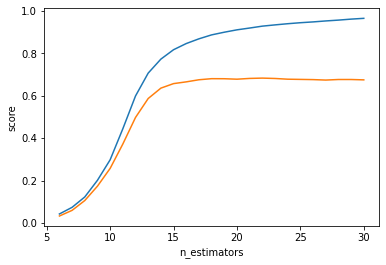

In [9]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(30, 5, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=r2_score, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [10]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=17

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=r2_score, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8084, train-score 2 = 0.9781
valid-score 1 = 0.4167, valid-score 2 = 0.7094
Train metric =  0.8639
Valid metric =  0.6804
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8016, train-score 2 = 0.9787
valid-score 1 = 0.5042, valid-score 2 = 0.6518
Train metric =  0.8694
Valid metric =  0.701
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8015, train-score 2 = 0.98
valid-score 1 = 0.4756, valid-score 2 = 0.6685
Train metric =  0.8752
Valid metric =  0.6465
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8009, train-score 2 = 0.9774
valid-score 1 = 0.571, valid-score 2 = 0.6669
Train metric =  0.868
Valid metric =  0.6893
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8193, train-score 2 = 0.976
valid-score 1 = 0.4619, valid-score 2 = 0.7327
Train metric =  0.8677
Valid metric =  0.6614
C

In [11]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(test_pred_2).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1639.152954,0.048642
1,512327,1668.477661,0.074114
2,512328,1645.428833,0.103768
3,512331,1657.093994,0.111282
4,512333,1664.839233,0.084603


In [12]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-17_all_feats_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-17_all_feats_2021-10-31_06-47-07.csv

 File saved to disk!
